In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/50028.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/18054.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/32154.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/51742.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/60154.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/22739.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/59655.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/20985.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/57328.png
/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged/49613.png
/kaggle

Visualize one image + its mask to confirm alignment.

(1200, 1600)


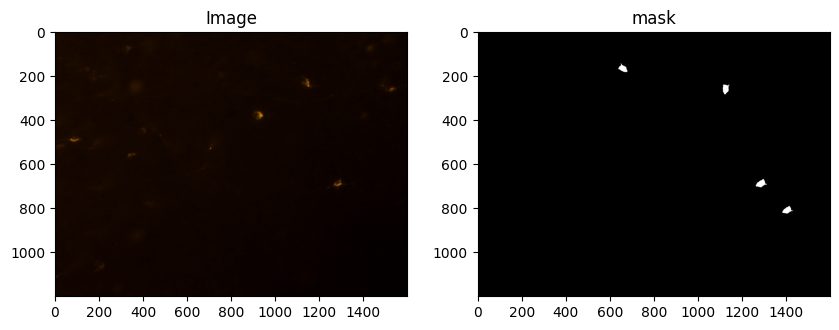

In [14]:
import cv2, matplotlib.pyplot as plt, numpy as np
import os

image_path = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/authentic/10015.png"
mask_path = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_masks/10015.npy"

img = cv2.imread(image_path)
mask = np.load(mask_path)
mask = np.squeeze(mask)

print(mask.shape)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('on')

plt.subplot(1,2,2)
plt.imshow(mask,cmap='gray')
plt.title('mask')
plt.axis('on')
plt.show()



Create a PyTorch Dataset that returns (image_tensor, mask_tensor).

In [8]:
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A

transform = A.Compose([
    A.Resize(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
    ToTensorV2(), 
])

class ForgeryDataset(Dataset):
    def __init__(self, image_dir,mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_name = self.images[index]
        img = cv2.imread(os.path.join(self.image_dir,img_name))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_dir, img_name)
        mask = cv2.imread(mask_path,0)
        mask = (mask>0).astype('float32')

        if self.transform:
            augumented = self.transform(image=img,mask=mask)
            img= augumented['image']
            mask = augumented['mask'].unsqueeze(0)
        return img,mask
            
        


In [15]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 23.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nv

In [16]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weight = 'imagenet',
    in_channel= 3,
    classes = 1,
    activation=None
)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]